## IN3050/IN4050 Mandatory Assignment 2, 2025: Supervised Learning



### Delivery of Nora Jeanett Tønnessen, norajto@uio.no




### Goals of the assignment
The goal of this assignment is to get a better understanding of supervised learning with gradient descent. It will, in particular, consider the similarities and differences between linear classifiers and multi-layer feed forward neural networks (multi-layer perceptrons, MLP) and the differences and similarities between binary and multi-class classification. 

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use machine learning libraries like Scikit-Learn or PyTorch, because the point of this assignment is for you to implement things from scratch. You, however, are encouraged to use tools like NumPy, Pandas and MatPlotLib, which are not ML-specific.

The given precode uses NumPy. You are recommended to use NumPy since it results in more compact code, but feel free to use pure Python if you prefer. 

If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your own and explain them!

### Initialization

In [312]:
!pip install scikit-learn


In [313]:
!pip install pandas

In [314]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn # This is only to generate a dataset
import pandas as pd 
import matplotlib.pyplot as plt 


## Datasets

We start by making a synthetic dataset of 5000 instances and ten classes, with 500 instances in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data. In addition, we would like a dataset with instances represented with only two numerical features, so that it is easy to visualize the data. It would be rather difficult (although not impossible) to find a real-world dataset of the same nature. Anyway, you surely can use the code in this assignment for training machine learning models on real-world datasets.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training, on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by Scikit-Learn, but that will not be the case with real-world data) We should split the data so that we keep the alignment between X (features) and t (class labels), which may be achieved by shuffling the indices. We split into 60% for training, 20% for validation, and 20% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(424242)`.

In [315]:
# Generating the dataset
from sklearn.datasets import make_blobs
X, t_multi = make_blobs(n_samples=[500, 500, 500, 500, 500, 500, 500, 500, 500, 500], centers=[[0,1],[4,2],[8,1],[2,0],[6,0],[3,-3],[4,-2],[0,5],[0,4],[-2,-2]], 
                  n_features=2, random_state=424242, cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5, 3.0, 1.0, 0.5, 2.5, 2.5])

In [316]:
# Shuffling the dataset
indices = np.arange(X.shape[0])
rng = np.random.RandomState(424242)
rng.shuffle(indices)
indices[:10]

array([3560, 4674,   49, 1257,  661, 3066, 3834, 4792,  570, 3855])

In [317]:
# Splitting into train, dev and test
X_train = X[indices[:3000],:]
X_val = X[indices[3000:4000],:]
X_test = X[indices[4000:],:]
t_multi_train = t_multi[indices[:3000]]
t_multi_val = t_multi[indices[3000:4000]]
t_multi_test = t_multi[indices[4000:]]

Next, we will  make a second dataset with only two classes by merging the existing labels in (X,t), so that `0-5` become the new `0` and `6-9` become the new `1`. Let's call the new set (X, t2). This will be a binary set.
We now have two datasets:

- Binary set: `(X, t2)`
- Multi-class set: `(X, t_multi)`

In [318]:
t2_train = t_multi_train >= 6
t2_train = t2_train.astype("int")
t2_val = (t_multi_val >= 6).astype("int")
t2_test = (t_multi_test >= 6).astype("int")

We can plot the two traning sets.

Text(0.5, 1.0, 'Multi-class set')

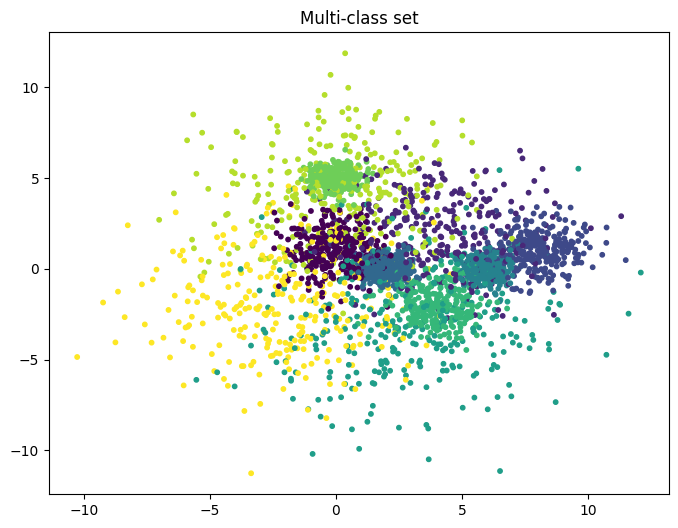

In [319]:
plt.figure(figsize=(8,6)) # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_multi_train, s=10.0)
plt.title("Multi-class set")

Text(0.5, 1.0, 'Binary set')

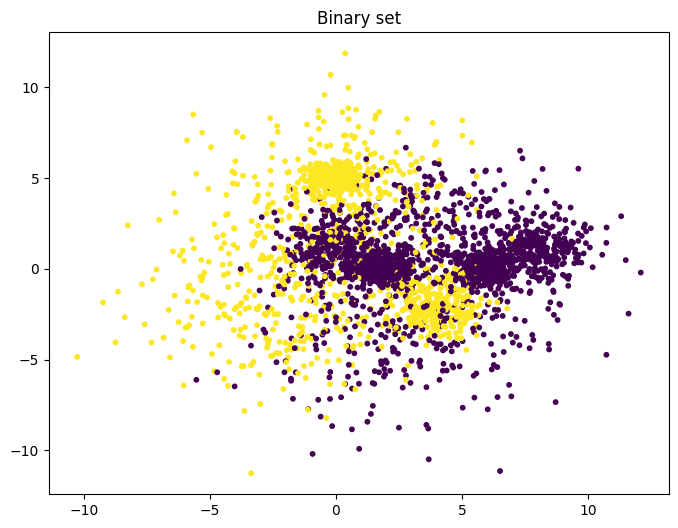

In [320]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=10.0)
plt.title("Binary set")

# Part 1: Linear classifiers
### Linear regression

Får en linjær klassifikasjon: 100, kom jo nærmere 1 som mulig 

Tune den. scale den.

We see that even the binary set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression with the Mean Squared Error (MSE) loss, although it is not the most widely used approach for classification tasks: but we are interested. You may make your own implementation from scratch or start with the solution to the weekly exercise set 6. We include it here with a little added flexibility.

In [321]:
def add_bias(X, bias):
    """X is a NxM matrix: N datapoints, M features
    bias is a bias term, -1 or 1, or any other scalar. Use 0 for no bias
    Return a Nx(M+1) matrix with added bias in position zero
    """
    N = X.shape[0]
    biases = np.ones((N, 1)) * bias # Make a N*1 matrix of biases
    # Concatenate the column of biases in front of the columns of X.
    return np.concatenate((biases, X), axis  = 1) 

In [322]:
class NumpyClassifier():
    """Common methods to all Numpy classifiers --- if any"""

In [323]:
class NumpyLinRegClass(NumpyClassifier):

    def __init__(self, bias=-1):
        self.bias=bias
    
    def fit(self, X_train, t_train, lr = 0.1, epochs=10):
        """X_train is a NxM matrix, N data points, M features
        t_train is avector of length N,
        the target class values for the training data
        lr is our learning rate
        """
        
        if self.bias:
            X_train = add_bias(X_train, self.bias)
            
        (N, M) = X_train.shape
        
        self.weights = weights = np.zeros(M)
        
        for epoch in range(epochs):
            # print("Epoch", epoch)
            weights -= lr / N *  X_train.T @ (X_train @ weights - t_train)      
    
    def predict(self, X, threshold=0.5):
        """X is a KxM matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold

We can train and test a first classifier (on the binary dataset).

In [324]:
def accuracy_score(predicted, gold):
    return np.mean(predicted == gold)

In [325]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train, epochs=10)
accuracy_score(cl.predict(X_val), t2_val)


np.float64(0.638)

The following is a small procedure which plots the data set together with the decision boundaries. 
You may modify the colors and the rest of the graphics as you like.
The procedure will also work for multi-class classifiers

In [326]:
def plot_decision_regions(X, t, clf=[], size=(8,6)):
    """Plot the data set (X,t) together with the decision boundary of the classifier clf"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Make a prediction of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Classify each meshpoint.
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'tab10')

    plt.scatter(X[:,0], X[:,1], c=t, s=10.0, cmap='tab10')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")

#    plt.show()

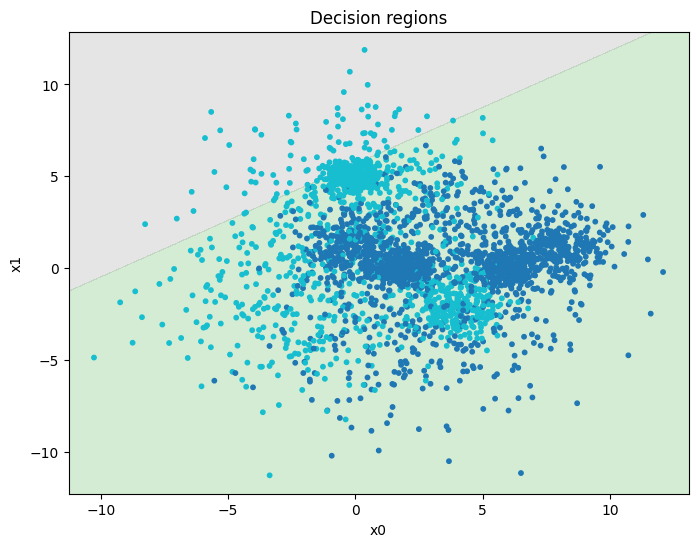

In [327]:
plot_decision_regions(X_train, t2_train, cl)

### Task: Tuning

The result is far from impressive. 
Remember that a classifier which always chooses the majority class will have an accuracy of 0.6 on this data set.

Your task is to try various settings for the two training hyper-parameters, learning rate and the number of epochs, to get the best accuracy on the validation set. 

Report how the accuracy varies with the hyper-parameter settings. It it not sufficient to give the final hyperparameters. You must also show how you found then and results for alternative values you tried aout.

When you are satisfied with the result, you may plot the decision boundaries, as above.

Validation accuracy for all combinations:



,Learning Rate,Epochs,Accuracy
0,0.01,250,0.771
1,0.05,50,0.771
2,0.01,300,0.769
3,0.02,150,0.768
4,0.03,100,0.768
5,0.06,50,0.768
6,0.01,200,0.762
7,0.01,350,0.762
8,0.01,500,0.762
9,0.02,250,0.762



Best hyperparameters found:
  Learning rate:       0.01
  Epochs:              250
  Validation accuracy: 0.771

Final accuracy on validation set: 0.771


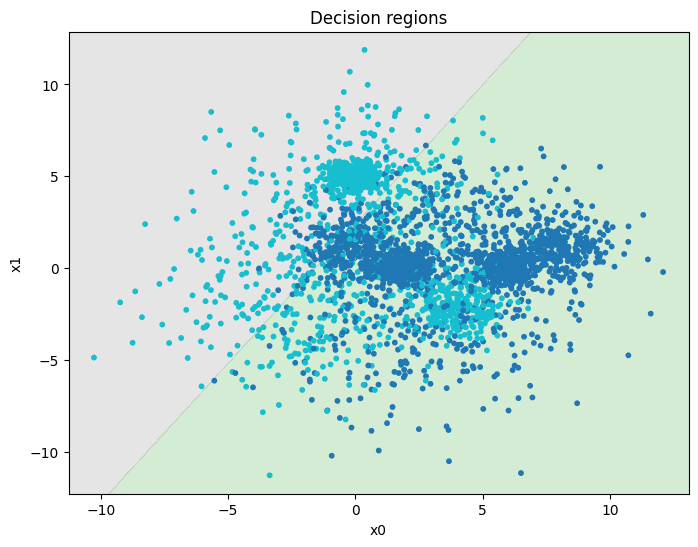

In [328]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def tune_hyperparameters(X_train, X_val, t_train, t_val):
    results = {}
    learning_rates = np.arange(0.01, 0.11, 0.01)
    epochs = np.arange(50, 501, 50)

    # Train and evaluate for each combination of learning rate and number of epochs
    for lr in learning_rates:
        for ep in epochs:
            model = NumpyLinRegClass()
            model.fit(X_train, t_train, lr=lr, epochs=ep)
            acc = accuracy_score(model.predict(X_val), t_val)
            results[(lr, ep)] = acc

    # Sort all results by accuracy (descending)
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

    # Display results in a formatted table
    df = pd.DataFrame([
        {"Learning Rate": lr, "Epochs": ep, "Accuracy": acc}
        for (lr, ep), acc in sorted_results
    ])
    print("Validation accuracy for all combinations:\n")
    display(df.style.format({"Learning Rate": "{:.2f}", "Accuracy": "{:.3f}"}))

    # Extract the best parameters
    best_params = sorted_results[0][0]
    best_accuracy = sorted_results[0][1]
    best_lr, best_epochs = best_params

    print("\nBest hyperparameters found:")
    print(f"  Learning rate:       {best_lr:.2f}")
    print(f"  Epochs:              {best_epochs}")
    print(f"  Validation accuracy: {best_accuracy:.3f}")

    return best_lr, best_epochs, best_accuracy

# Run tuning
best_lr, best_epochs, best_acc = tune_hyperparameters(X_train, X_val, t2_train, t2_val)

# Train the final model with best hyperparameters
model = NumpyLinRegClass()
model.fit(X_train, t2_train, lr=best_lr, epochs=best_epochs)

# Evaluate on validation set
val_acc = accuracy_score(model.predict(X_val), t2_val)
print(f"\nFinal accuracy on validation set: {val_acc:.3f}")

# Plot decision boundary (optional)
plot_decision_regions(X_train, t2_train, clf=model)


### Task: Scaling

We have seen in the lectures that scaling the data may improve training speed and sometimes the performance. 

- Implement the standard scaler (normalizer); you can also try other scaling techniques
- Scale the data
- Train the model on the scaled data
- Experiment with hyper-parameter settings and see whether you can speed  up or improve the training.
- Report final hyper-parameter settings and show how you found them.

 Results after scaling:
  Learning rate: 0.01
  Epochs: 250
  Accuracy before scaling: 0.771
  Accuracy after scaling:  0.757


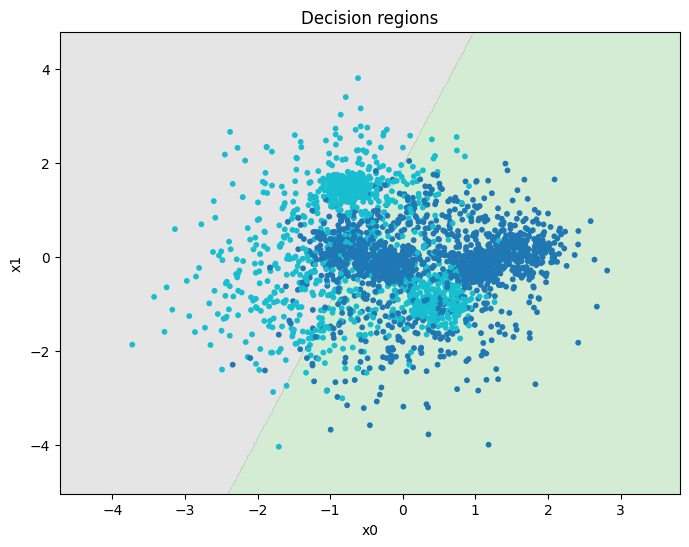

In [329]:
def standard_scaler(X, means=None, stds=None):
    X_scaled = X.copy()
    if means is None or stds is None:
        means = np.mean(X_scaled, axis=0)
        stds = np.std(X_scaled, axis=0)
    return (X_scaled - means) / stds, means, stds

# 1. Skaler trenings- og valideringssett
X_train_scaled, means, stds = standard_scaler(X_train)
X_val_scaled, _, _ = standard_scaler(X_val, means, stds)

# 2. Tren modell med tidligere beste hyperparametere
scaled_model = NumpyLinRegClass()
scaled_model.fit(X_train_scaled, t2_train, lr=best_lr, epochs=best_epochs)

# 3. Evaluer modell
val_acc_scaled = accuracy_score(scaled_model.predict(X_val_scaled), t2_val)

# 4. Rapportér resultat
print(" Results after scaling:")
print(f"  Learning rate: {best_lr}")
print(f"  Epochs: {best_epochs}")

print(f"  Accuracy before scaling: {val_acc:.3f}")
print(f"  Accuracy after scaling:  {val_acc_scaled:.3f}")
plot_decision_regions(X_train_scaled, t2_train, clf=scaled_model)




## Logistic regression
a) You should now implement a logistic regression classifier similarly to the classifier based on linear regression.
You may use the code from the solution to weekly exercise set week06.

b) In addition to the method `predict()` which predicts a class for the data, include a method `predict_probabilities()` which predicts the probability of the data belonging to the positive class.

c) So far, we have not calculated the loss explicitly in the code. Extend the code to calculate the loss on the training set for each epoch and to store the losses such that the losses can be inspected after training. The prefered loss for logistic regression is binary cross-entropy, but you can also try mean squared error. The most important is that your implementation of the loss corresponds to your implementation of the gradient descent.
Also, calculate and store accuracies after each epoch.

d) In addition, extend the `fit()` method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to `fit()`, calculate the loss and the accuracy for the validation set after each epoch. 

e) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the `fit()` method with two keyword arguments, `tol` (tolerance) and `n_epochs_no_update` and stop training when the loss has not improved with more than `tol` after `n_epochs_no_update` (to save compute and potentially avoid over-fitting). A possible default value for `n_epochs_no_update` is 2. Also, add an attribute to the classifier which tells us after fitting how many epochs it was trained for.

f) Train classifiers with various learning rates, and with varying values for `tol` for finding the optimal values. Also consider the effect of scaling the data.

g) After a succesful training, for your best model, plot both training loss and validation loss as functions of the number of epochs in one figure, and both training and validation accuracies as functions of the number of epochs in another figure. Comment on what you see. Are the curves monotone? Is this as expected?

In [ ]:
# Importerer numpy for vektor- og matriseoperasjoner
import numpy as np

# Sigmoid-funksjon brukes til å konvertere lineær output til sannsynligheter mellom 0 og 1. Tar den linjære kombinasjonen og returnerer et tall mellom 0 og 1
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Klasse for binær logistisk regresjon (trening, prediksjon og logging)
class NumpyLogRegClass:
    def __init__(self, bias=-1):
        # Initialiserer modellen med opsjonell bias-verdi (standard -1)
        self.bias = bias  # Brukes for å legge til en ekstra bias-feature i datasettet
        self.weights = None  # Modellens vekter initialiseres i fit()
        self.train_losses = []  # Lagrer loss-verdier for hver trenings-epoch
        self.train_accuracies = []  # Lagrer nøyaktighet for hver trenings-epoch
        self.val_losses = []  # Lagrer loss på valideringssettet (hvis gitt)
        self.val_accuracies = []  # Lagrer nøyaktighet på valideringssettet (hvis gitt)
        self.trained_epochs = 0  # Antall epoker som faktisk ble trent

    # Treningsfunksjon med støtte for early stopping og valideringssett
    def fit(self, X_train, t_train, lr=0.1, epochs=100,
            X_val=None, t_val=None, tol=1e-4, n_epochs_no_update=2):

        # Legger til bias-kolonne (ekstra funksjon med konstant verdi)
        if self.bias:
            X_train = add_bias(X_train, self.bias)  # Legger til bias i treningsdata
            if X_val is not None:
                X_val = add_bias(X_val, self.bias)  # Legger til bias i valideringsdata

        N, M = X_train.shape  # N = antall datapunkter, M = antall features
        self.weights = np.zeros(M)  # Initialiserer vektene som null
        best_val_loss = np.inf  # Brukes til å spore beste valideringsloss
        no_update = 0  # Teller hvor mange epoker uten forbedring

        # Hovedtreningsløkke
        for epoch in range(epochs):
            # Fremoverpass: beregn sannsynligheter ved å bruke sigmoid
            y_train = sigmoid(X_train @ self.weights)

            # Beregn binær krysstaps-loss (log loss)
            eps = 1e-10  # For å unngå log(0)
            train_loss = -np.mean(t_train * np.log(y_train + eps) + (1 - t_train) * np.log(1 - y_train + eps))
            self.train_losses.append(train_loss)  # Logger loss

            # Beregn treningsnøyaktighet
            train_pred = (y_train > 0.5).astype(int)  # Terskel = 0.5
            train_acc = np.mean(train_pred == t_train)
            self.train_accuracies.append(train_acc)

            # Evaluer på valideringssett, hvis det finnes
            if X_val is not None and t_val is not None:
                y_val = sigmoid(X_val @ self.weights)  # Valideringsprediksjoner
                val_loss = -np.mean(t_val * np.log(y_val + eps) + (1 - t_val) * np.log(1 - y_val + eps))
                val_acc = np.mean((y_val > 0.5).astype(int) == t_val)

                self.val_losses.append(val_loss)  # Logger valideringsloss
                self.val_accuracies.append(val_acc)  # Logger valideringsnøyaktighet

                # Early stopping-logikk
                if val_loss > best_val_loss - tol:
                    no_update += 1  # Ingen forbedring, teller opp
                else:
                    best_val_loss = val_loss  # Ny beste loss
                    no_update = 0  # Resett teller

                # Stopp hvis modellen ikke har forbedret seg på n_epochs_no_update epoker
                if no_update >= n_epochs_no_update:
                    print(f" Early stopping at epoch {epoch+1}")
                    self.trained_epochs = epoch + 1  # Lagre hvor langt vi kom
                    return  # Avslutt treningen
            else:
                # Hvis ingen valideringsdata, logger vi None
                self.val_losses.append(None)
                self.val_accuracies.append(None)

            # Gradient descent: oppdater vektene
            self.weights -= lr / N * X_train.T @ (y_train - t_train)

        # Lagre faktisk antall epoker dersom early stopping ikke skjedde
        self.trained_epochs = epochs

    # Returnerer sannsynlighetene for klasse 1
    def predict_probabilities(self, X):
        if self.bias:
            X = add_bias(X, self.bias)  # Legg til bias hvis nødvendig
        return sigmoid(X @ self.weights)  # Bruk sigmoid for å få sannsynlighet

    # Returnerer 0 eller 1 basert på terskel (standard 0.5)
    def predict(self, X, threshold=0.5):
        return (self.predict_probabilities(X) > threshold).astype(int)


In [ ]:
# Initialiser modellen
log_model = NumpyLogRegClass()

# Tren modellen med gitt læringsrate, epoker og early stopping-parametere
log_model.fit(X_train, t2_train, lr=0.05, epochs=300,
              X_val=X_val, t_val=t2_val, tol=0.001, n_epochs_no_update=5)

# Skriv ut hvor mange epoker den faktisk trente
print(f"Trained for {log_model.trained_epochs} epochs")


 Early stopping at epoch 22
Trained for 22 epochs


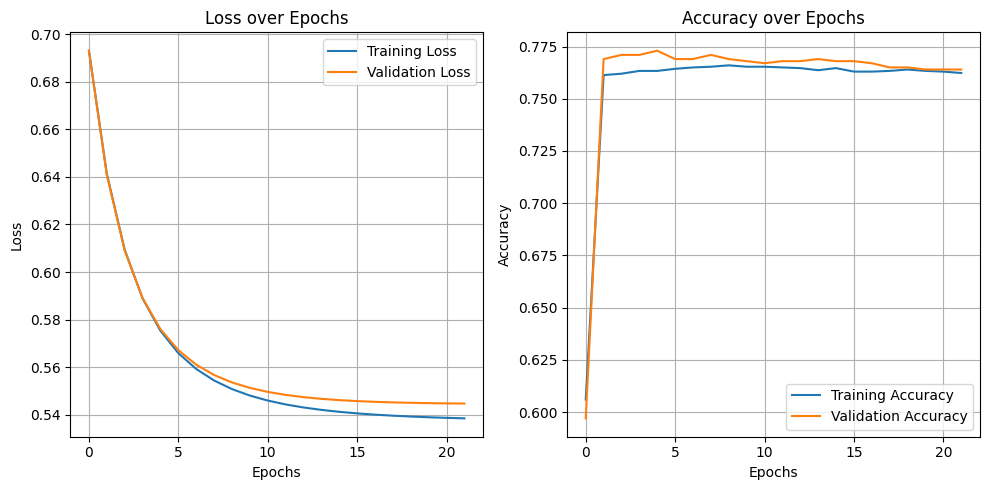

In [ ]:
import matplotlib.pyplot as plt  # Brukes til å lage figurer

# Lag ny figur med to plott ved siden av hverandre
plt.figure(figsize=(10, 5))

# --- Plot Loss ---
plt.subplot(1, 2, 1)  # Første subplot
plt.plot(log_model.train_losses, label="Training Loss")  # Trenings-loss
plt.plot(log_model.val_losses, label="Validation Loss")  # Validerings-loss
plt.xlabel("Epochs")  # X-akse: antall epoker
plt.ylabel("Loss")  # Y-akse: loss
plt.title("Loss over Epochs")  # Tittel
plt.legend()  # Vis forklaring
plt.grid(True)  # Rutenett

# --- Plot Accuracy ---
plt.subplot(1, 2, 2)  # Andre subplot
plt.plot(log_model.train_accuracies, label="Training Accuracy")  # Trenings-nøyaktighet
plt.plot(log_model.val_accuracies, label="Validation Accuracy")  # Validerings-nøyaktighet
plt.xlabel("Epochs")  # X-akse
plt.ylabel("Accuracy")  # Y-akse
plt.title("Accuracy over Epochs")  # Tittel
plt.legend()  # Vis forklaring
plt.grid(True)  # Rutenett

# Juster layout og vis figuren
plt.tight_layout()
plt.show()


In [333]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(X, y, model, resolution=0.02):
    colors = ('lightgray', 'lightgreen')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    X_grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(X_grid).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=cmap)
    plt.title("Decision Regions (Logistic Regression)")
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.show()


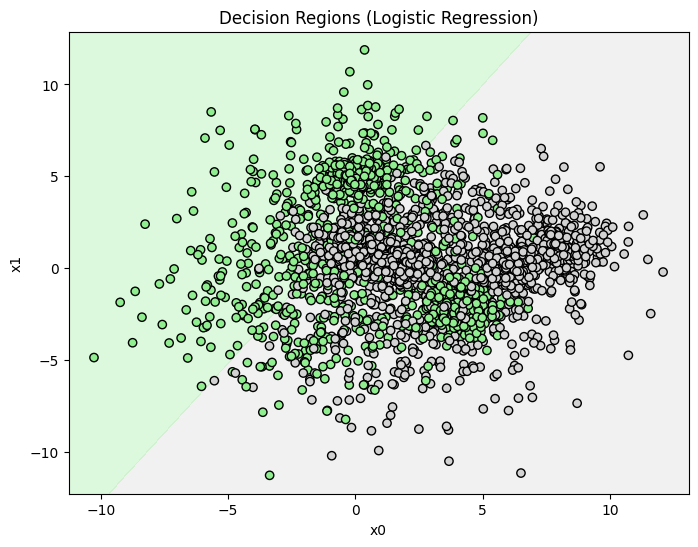

In [334]:
plot_decision_boundary(X_train, t2_train, model)


Both the training and validation losses decrease steadily over the epochs, indicating that the model is learning effectively. 
The overall downward trend suggests consistent improvement. 
The validation loss remains below the training loss, which may imply that the model generalizes well and is not overfitting.

The training and validation accuracies also improve with the number of epochs, though some fluctuations are present. 
The validation accuracy reaches a slightly higher level than the training accuracy. 


## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set `(X, t_multi)`.

### Multi-class with logistic regression
We saw in the lectures how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one logistic regression classifier for each class. To predict the class of an item, we run all the binary classifiers and collect the probability score from each of them. We assign the class which ascribes the highest probability.

Build such a classifier. Train the resulting classifier on `(X_train, t_multi_train)`, test it on `(X_val, t_multi_val)`, tune the hyper-parameters and report the accuracy.

Also plot the decision boundaries for your best classifier similarly to the plots for the binary case.

Validation accuracy for all combinations:



,Learning Rate,Epochs,Accuracy
99,0.10,500,0.533
89,0.09,500,0.522
98,0.10,450,0.522
88,0.09,450,0.514
79,0.08,500,0.512
97,0.10,400,0.512
78,0.08,450,0.494
87,0.09,400,0.494
96,0.10,350,0.492
69,0.07,500,0.492



Best hyperparameters found:
  Learning rate:       0.10
  Epochs:              500
  Validation accuracy: 0.533

Final accuracy on validation set: 0.533


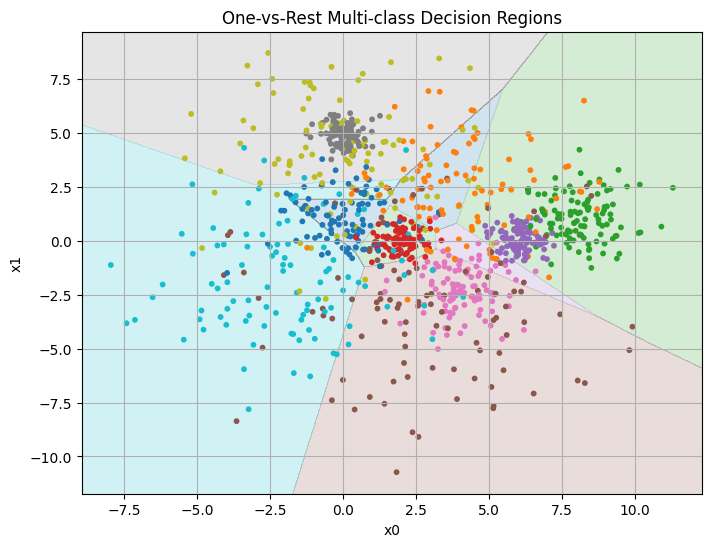

In [335]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class OneVsRestLogReg:
    def __init__(self, num_classes, bias=-1):
        # Initialize one binary classifier per class
        self.num_classes = num_classes
        self.bias = bias
        self.models = [NumpyLogRegClass(bias=self.bias) for _ in range(num_classes)]

    def fit(self, X_train, t_train, lr=0.1, epochs=100, tol=1e-4, n_epochs_no_update=3):
        # Train one-vs-rest classifiers
        for class_id in range(self.num_classes):
            binary_targets = (t_train == class_id).astype(int)
            self.models[class_id].fit(
                X_train, binary_targets,
                lr=lr, epochs=epochs,
                tol=tol, n_epochs_no_update=n_epochs_no_update
            )

    def predict(self, X):
        # Get probabilities from all models and choose the class with highest score
        probas = np.array([model.predict_probabilities(X) for model in self.models])
        return np.argmax(probas, axis=0)

    def accuracy(self, X, t_true):
        # Compute accuracy of predictions
        t_pred = self.predict(X)
        return np.mean(t_pred == t_true)

# Tried using the one over, but i did not have time trying 
def tune_hyperparameters(X_train, X_val, t_train, t_val):
    results = {}
    learning_rates = np.arange(0.01, 0.11, 0.01)
    epochs_list = np.arange(50, 501, 50)
    num_classes = len(np.unique(t_train))

    

    # Try all combinations of learning rates and epoch counts
    for lr in learning_rates:
        for ep in epochs_list:
            model = OneVsRestLogReg(num_classes=num_classes)
            model.fit(X_train, t_train, lr=lr, epochs=ep, tol=0.001)
            acc = model.accuracy(X_val, t_val)
            results[(lr, ep)] = acc

    # Display results in a sorted DataFrame
    df_results = pd.DataFrame([
        {"Learning Rate": lr, "Epochs": ep, "Accuracy": acc}
        for (lr, ep), acc in results.items()
    ])
    df_sorted = df_results.sort_values(by="Accuracy", ascending=False)

    print("Validation accuracy for all combinations:\n")
    display(df_sorted.style.format({"Learning Rate": "{:.2f}", "Accuracy": "{:.3f}"}))

    # Select the best combination
    best_row = df_sorted.iloc[0]
    best_lr = best_row["Learning Rate"]
    best_epochs = best_row["Epochs"]
    best_acc = best_row["Accuracy"]

    print("\nBest hyperparameters found:")
    print(f"  Learning rate:       {best_lr:.2f}")
    print(f"  Epochs:              {int(best_epochs)}")
    print(f"  Validation accuracy: {best_acc:.3f}")

    return best_lr, int(best_epochs), best_acc


def plot_multiclass_decision_regions(X, t, clf, size=(8,6)):
    # Create a grid of input points
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02  # step size

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    X_grid = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.predict(X_grid)
    Z = Z.reshape(xx.shape)

    # Plot decision boundaries and training points
    plt.figure(figsize=size)
    plt.contourf(xx, yy, Z, alpha=0.2, cmap='tab10')
    plt.scatter(X[:, 0], X[:, 1], c=t, s=10.0, cmap='tab10')
    plt.title("One-vs-Rest Multi-class Decision Regions")
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.grid(True)
    plt.show()




best_lr, best_epochs, best_acc = tune_hyperparameters(X_train, X_val, t_multi_train, t_multi_val)


num_classes = len(np.unique(t_multi_train))
ovr_model = OneVsRestLogReg(num_classes=num_classes)
ovr_model.fit(X_train, t_multi_train, lr=best_lr, epochs=best_epochs, tol=0.001)


val_acc = ovr_model.accuracy(X_val, t_multi_val)
print(f"\nFinal accuracy on validation set: {val_acc:.3f}")


plot_multiclass_decision_regions(X_val, t_multi_val, ovr_model)




### For IN4050 students: Multinomial logistic regression
The following part is only mandatory for IN4050 students. IN3050 students are also welcome to make it a try. Everybody has to do the part 2 on multi-layer neural networks. 

In the lectures, we contrasted the one-vs-rest approach with the multinomial logistic regression, also called softmax classifier. Implement also this classifier, tune the parameters, and compare the results to the classifiers above. (Don't expect a large difference on a simple task like this.)

Remember that this classifier uses softmax in the forward phase. For loss, it uses categorical cross-entropy loss. The loss has a somewhat simpler form than in the binary case. To calculate the gradient is a little more complicated. The actual gradient and update rule is simple, however, as long as you have calculated the forward values correctly.

Our classifier is not ideal. But is it because all the 10 classes are equally diffucult to predict?
You should evaluate the multinomial model predictions for each class separately and report your findings.
Please also report whether there is any difference in this respect between the training and the validation sets.

In [336]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class SoftmaxClassifier:
    def __init__(self, num_classes, bias=True):
        self.num_classes = num_classes
        self.bias = bias
        self.weights = None

    def _add_bias(self, X):
        if not self.bias:
            return X
        N = X.shape[0]
        return np.concatenate([np.ones((N, 1)), X], axis=1)

    def _softmax(self, Z):
        Z -= np.max(Z, axis=1, keepdims=True)  # numerical stability
        expZ = np.exp(Z)
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def _one_hot(self, t, num_classes):
        return np.eye(num_classes)[t]

    def fit(self, X_train, t_train, lr=0.1, epochs=300):
        X = self._add_bias(X_train)
        N, D = X.shape
        C = self.num_classes
        T = self._one_hot(t_train, C)

        self.weights = np.zeros((D, C))

        for epoch in range(epochs):
            logits = X @ self.weights
            probs = self._softmax(logits)
            loss = -np.mean(np.sum(T * np.log(probs + 1e-10), axis=1))  # cross-entropy

            # gradient descent update
            grad = X.T @ (probs - T) / N
            self.weights -= lr * grad

    def predict(self, X):
        X = self._add_bias(X)
        logits = X @ self.weights
        probs = self._softmax(logits)
        return np.argmax(probs, axis=1)

    def accuracy(self, X, t_true):
        t_pred = self.predict(X)
        return np.mean(t_pred == t_true)


In [337]:
def tune_softmax_hyperparameters(X_train, X_val, t_train, t_val, num_classes):
    results = {}
    learning_rates = np.arange(0.01, 0.11, 0.01)
    epochs_list = np.arange(100, 501, 100)

    for lr in learning_rates:
        for ep in epochs_list:
            model = SoftmaxClassifier(num_classes=num_classes)
            model.fit(X_train, t_train, lr=lr, epochs=ep)
            acc = model.accuracy(X_val, t_val)
            results[(lr, ep)] = acc

    # Format result output
    df = pd.DataFrame([
        {"Learning Rate": lr, "Epochs": ep, "Accuracy": acc}
        for (lr, ep), acc in results.items()
    ])
    df_sorted = df.sort_values(by="Accuracy", ascending=False)
    display(df_sorted.style.format({"Learning Rate": "{:.2f}", "Accuracy": "{:.3f}"}))

    best_row = df_sorted.iloc[0]
    best_lr = best_row["Learning Rate"]
    best_epochs = best_row["Epochs"]
    best_acc = best_row["Accuracy"]

    print("\nBest hyperparameters:")
    print(f"  Learning rate:       {best_lr:.2f}")
    print(f"  Epochs:              {int(best_epochs)}")
    print(f"  Validation accuracy: {best_acc:.3f}")

    return best_lr, int(best_epochs), best_acc


In [338]:
def plot_multiclass_decision_regions(X, t, clf, size=(8,6), title="Softmax Decision Regions"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    X_grid = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.predict(X_grid).reshape(xx.shape)

    plt.figure(figsize=size)
    plt.contourf(xx, yy, Z, alpha=0.2, cmap='tab10')
    plt.scatter(X[:, 0], X[:, 1], c=t, s=10.0, cmap='tab10')
    plt.title(title)
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.grid(True)
    plt.show()


,Learning Rate,Epochs,Accuracy
49,0.10,500,0.660
44,0.09,500,0.652
39,0.08,500,0.646
48,0.10,400,0.646
43,0.09,400,0.638
34,0.07,500,0.637
38,0.08,400,0.633
47,0.10,300,0.629
29,0.06,500,0.629
33,0.07,400,0.624



Best hyperparameters:
  Learning rate:       0.10
  Epochs:              500
  Validation accuracy: 0.660

Final validation accuracy: 0.660


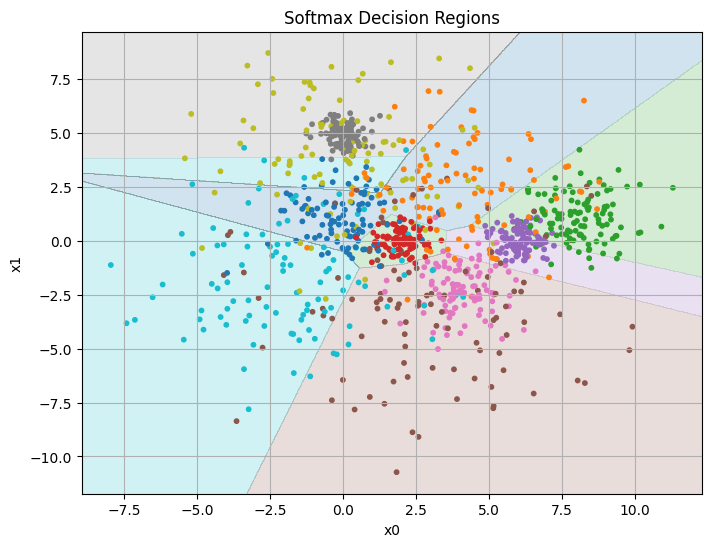

In [339]:
#  Get number of classes
num_classes = len(np.unique(t_multi_train))

#  Tune
best_lr, best_epochs, best_acc = tune_softmax_hyperparameters(
    X_train, X_val, t_multi_train, t_multi_val, num_classes
)

#  Train final model
softmax_model = SoftmaxClassifier(num_classes=num_classes)
softmax_model.fit(X_train, t_multi_train, lr=best_lr, epochs=best_epochs)

# Evaluate
val_acc = softmax_model.accuracy(X_val, t_multi_val)
print(f"\nFinal validation accuracy: {val_acc:.3f}")


plot_multiclass_decision_regions(X_val, t_multi_val, softmax_model)


In [340]:
def per_class_accuracy(X, t_true, model):
    t_pred = model.predict(X)
    accs = []
    for c in np.unique(t_true):
        class_idx = (t_true == c)
        acc = np.mean(t_pred[class_idx] == t_true[class_idx])
        accs.append((c, acc))
    return accs

print("\nAccuracy per class (validation set):")
for c, acc in per_class_accuracy(X_val, t_multi_val, softmax_model):
    print(f"  Class {c}: {acc:.3f}")



Accuracy per class (validation set):
  Class 0: 0.667
  Class 1: 0.556
  Class 2: 0.935
  Class 3: 0.956
  Class 4: 0.588
  Class 5: 0.490
  Class 6: 0.598
  Class 7: 0.990
  Class 8: 0.196
  Class 9: 0.650


The softmax classifier gives similar accuracy to the one-vs-rest model, but it handles all classes at once instead of training one model per class. This makes it simpler and often gives smoother decision boundaries.

# Part 2 Multi-layer neural networks

## A first non-linear classifier

The following code is a simple implementation of a multi-layer perceptron or feed-forward neural network.
For now, it is quite restricted.
There is only one hidden layer with 6 neurons.
It can only handle binary classification.
In addition, it uses a simple final layer similar to the linear regression classifier above.
One way to look at it is what happens when we add a hidden layer to the linear regression classifier.

The MLP class below misses the implementation of the `forward()` function. Your first task is to implement it. 

Remember that in the forward pass, we "feed" the input to the model, the model processes it and produces the output. The function should make use of the logistic activation function and bias.

In [341]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

def logistic_diff(y):
    return y * (1 - y)

DENNE SKAL DU KOMMENTERE PÅ

/var/folders/v2/_yt5v6hs3g5902xqjspnnrw40000gn/T/ipykernel_2023/650568728.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Best Learning Rate: 0.100, Best Epochs: 500, Best Accuracy: 0.660
Best model validation accuracy: 0.834


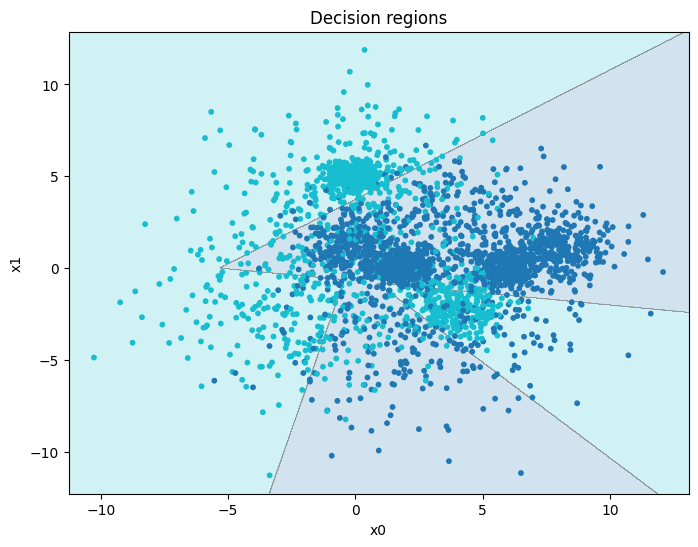

In [342]:
#  First, we define the logistic function and its derivative:
class MLPBinaryLinRegClass(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, bias=-1, dim_hidden=6):
        """Intialize the hyperparameters"""
        self.bias = bias
        self.dim_hidden = dim_hidden
        self.activ = logistic
        self.activ_diff = logistic_diff

    def forward(self, X):
        """TODO:
       Perform one forward step.
       Return a pair consisting of the outputs of the hidden_layer
       and the outputs on the final layer"""
       
        hidden_inputs = X @ self.weights1
        hidden_outs = self.activ(hidden_inputs)
        hidden_outs = np.hstack([np.ones((hidden_outs.shape[0], 1)) * self.bias, hidden_outs])
        final_inputs = hidden_outs @ self.weights2
        outputs = self.activ(final_inputs)
        return hidden_outs, outputs

    def fit(self, X_train, t_train, lr=0.001, epochs=100):
        """Initialize the weights. Train *epochs* many epochs.
             X_train is a NxM matrix, N data points, M features
         t_train is a vector of length N of targets values for the training␣ ↪data,
            where the values are 0 or 1. lr is the learning rate
        """

        T_train = t_train.reshape(-1, 1)
        dim_in = X_train.shape[1]
        dim_out = T_train.shape[1]

        self.weights1 = (np.random.rand(dim_in + 1, self.dim_hidden) * 2 - 1) / np.sqrt(dim_in)
        self.weights2 = (np.random.rand(self.dim_hidden + 1, dim_out) * 2 - 1) / np.sqrt(self.dim_hidden)

        X_train_bias = add_bias(X_train, self.bias)

        for _ in range(epochs):
            hidden_outs, outputs = self.forward(X_train_bias)
            out_deltas = outputs - T_train
            hiddenout_diffs = out_deltas @ self.weights2.T
            hiddenact_deltas = hiddenout_diffs[:, 1:] * self.activ_diff(hidden_outs[:, 1:])

            self.weights2 -= lr * hidden_outs.T @ out_deltas
            self.weights1 -= lr * X_train_bias.T @ hiddenact_deltas

    def predict(self, X):
        Z = add_bias(X, self.bias)
        _, outputs = self.forward(Z)
        return (outputs[:, 0] > 0.5).astype(int)
    
    
   
final_clf = MLPBinaryLinRegClass()
final_clf.fit(X_train, t2_train, lr=best_lr, epochs=best_epochs)


val_acc = accuracy_score(t2_val, final_clf.predict(X_val))


print(f"Best Learning Rate: {best_lr:.3f}, Best Epochs: {best_epochs}, Best Accuracy: {best_acc:.3f}")
print(f"Best model validation accuracy: {val_acc:.3f}")


plot_decision_regions(X_train, t2_train, final_clf)


When implemented, this model can be used to make a non-linear classifier for the set `(X, t2)`. Experiment with settings for learning rate and epochs and see how good results you can get. 
Report results for various settings. Be prepared to train for a long time (but you can control it via the number of epochs and hidden size). 

Plot the training set together with the decision regions as in Part I.

# Improving the MLP classifier
You should now make changes to the classifier similarly to what you did with the logistic regression classifier in part 1.

a) In addition to the `predict()` method, which predicts a class for the data, include the `predict_probabilities()` method which predict the probability of the data belonging to the positive class. The training should be based on these values, as with logistic regression.

b) Calculate the loss and the accuracy after each epoch and store them for inspection after training.

c) Extend the `fit()` method with optional arguments for a validation set `(X_val, t_val)`. If a validation set is included in the call to `fit()`, calculate the loss and the accuracy for the validation set after each epoch.

d) Extend the `fit()` method with two keyword arguments, `tol` (tolerance) and `n_epochs_no_update` and stop training when the loss has not improved for more than `tol` after `n_epochs_no_update`. A possible default value for `n_epochs_no_update` is 2. Add an attribute to the classifier which tells us after fitting how many epochs it was trained on.

e) Tune the hyper-parameters: `lr`, `tol` and `dim-hidden` (size of the hidden layer).
Also, consider the effect of scaling the data.

f) After a succesful training with the best setting for the hyper-parameters, plot both training loss and validation loss as functions of the number of epochs in one figure, and both training and validation accuracies as functions of the number of epochs in another figure. Comment on what you see.

g) The MLP algorithm contains an element of non-determinism. Hence, train the classifier 3 times with the optimal hyper-parameters and report the mean and standard deviation of the accuracies over the 3 runs.

In [343]:

def logistic(x):
    return 1 / (1 + np.exp(-x))

def logistic_diff(y):
    return y * (1 - y)  # derivative assuming y = logistic(x)

def add_bias(X, bias=-1):
    N = X.shape[0]
    return np.hstack([np.ones((N, 1)) * bias, X])


class MLPBinaryLinRegClass(NumpyClassifier):
    def __init__(self, bias=-1, dim_hidden=6):
        self.bias = bias
        self.dim_hidden = dim_hidden
        self.activ = logistic
        self.activ_diff = logistic_diff

        # logging
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.epochs_trained = 0

    def forward(self, X):
        hidden_inputs = X @ self.weights1
        hidden_outputs = self.activ(hidden_inputs)
        hidden_outputs = add_bias(hidden_outputs, self.bias)
        final_inputs = hidden_outputs @ self.weights2
        outputs = self.activ(final_inputs)
        return hidden_outputs, outputs

    def predict(self, X):
        X_bias = add_bias(X, self.bias)
        _, outputs = self.forward(X_bias)
        return (outputs[:, 0] > 0.5).astype(int)

    def predict_probabilities(self, X):
        X_bias = add_bias(X, self.bias)
        _, outputs = self.forward(X_bias)
        return outputs[:, 0]

    def fit(self, X_train, t_train, lr=0.01, epochs=500, tol=1e-4,
            n_epochs_no_update=10, X_val=None, t_val=None):

        t_train = t_train.reshape(-1, 1)
        dim_in = X_train.shape[1]
        dim_out = 1

        # Initialize weights with Xavier initialization
        self.weights1 = np.random.randn(dim_in + 1, self.dim_hidden) * np.sqrt(2 / (dim_in + 1))
        self.weights2 = np.random.randn(self.dim_hidden + 1, dim_out) * np.sqrt(2 / (self.dim_hidden + 1))

        X_train_bias = add_bias(X_train, self.bias)

        best_val_loss = float("inf")
        no_update = 0

        for epoch in range(epochs):
            #  Forward 
            hidden_outs, outputs = self.forward(X_train_bias)

            # Backward 
            out_deltas = outputs - t_train
            hiddenout_diffs = out_deltas @ self.weights2.T
            hiddenact_deltas = hiddenout_diffs[:, 1:] * self.activ_diff(hidden_outs[:, 1:])

            #  Update weights 
            self.weights2 -= lr * hidden_outs.T @ out_deltas
            self.weights1 -= lr * X_train_bias.T @ hiddenact_deltas

            #  Metrics 
            train_loss = np.mean((outputs - t_train) ** 2)
            train_acc = np.mean((outputs > 0.5).astype(int)[:, 0] == t_train[:, 0])
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)

            # Validation (optional) 
            if X_val is not None and t_val is not None:
                val_probs = self.predict_probabilities(X_val)
                val_loss = np.mean((val_probs.reshape(-1, 1) - t_val.reshape(-1, 1)) ** 2)
                val_acc = np.mean((val_probs > 0.5) == t_val)
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_acc)

                # === Early stopping check ===
                if val_loss < best_val_loss - tol:
                    best_val_loss = val_loss
                    no_update = 0
                else:
                    no_update += 1
                    if no_update >= n_epochs_no_update:
                        print(f"Early stopping at epoch {epoch+1}")
                        self.epochs_trained = epoch + 1
                        return
            else:
                self.val_losses.append(None)
                self.val_accuracies.append(None)

        self.epochs_trained = epochs



In [344]:

# Tuning 
lrs = [0.001, 0.005, 0.01]
epochs_list = [100, 200, 500]
best_acc = 0
results = {}

for lr in lrs:
    for ep in epochs_list:
        clf = MLPBinaryLinRegClass(dim_hidden=8)
        clf.fit(X_train, t2_train, lr=lr, epochs=ep, X_val=X_val, t_val=t2_val)
        acc = accuracy_score(t2_val, clf.predict(X_val))
        results[(lr, ep)] = acc

best_params = max(results, key=results.get)
best_lr, best_epochs = best_params
best_acc = results[best_params]



Early stopping at epoch 220
Early stopping at epoch 31
Early stopping at epoch 27
Early stopping at epoch 20
Early stopping at epoch 32
Early stopping at epoch 11
Early stopping at epoch 25



 Final Model Evaluation
Best Learning Rate       : 0.001
Best Epochs              : 200
Validation Accuracy      : 0.863
Training Accuracy        : 0.855
Epochs actually trained  : 200


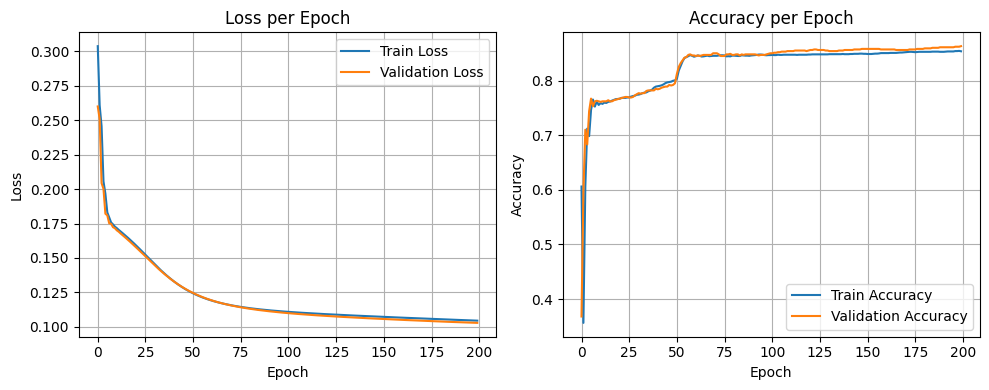

In [345]:
# Train best model 
best_clf = MLPBinaryLinRegClass(dim_hidden=8)
best_clf.fit(X_train, t2_train, lr=best_lr, epochs=best_epochs,
             X_val=X_val, t_val=t2_val)

# Accuracy and final loss 
train_acc = accuracy_score(t2_train, best_clf.predict(X_train))
val_acc = accuracy_score(t2_val, best_clf.predict(X_val))

print("\n Final Model Evaluation")
print(f"Best Learning Rate       : {best_lr}")
print(f"Best Epochs              : {best_epochs}")
print(f"Validation Accuracy      : {val_acc:.3f}")
print(f"Training Accuracy        : {train_acc:.3f}")
print(f"Epochs actually trained  : {best_clf.epochs_trained}")


#  Plot loss and accuracy 
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(best_clf.train_losses, label="Train Loss")
plt.plot(best_clf.val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(best_clf.train_accuracies, label="Train Accuracy")
plt.plot(best_clf.val_accuracies, label="Validation Accuracy")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [346]:
from sklearn.metrics import accuracy_score


# G oppgaven
validation_scores = []

for i in range(3):
    model = MLPBinaryLinRegClass(dim_hidden=8)
    model.fit(X_train, t2_train, lr=best_lr, epochs=best_epochs,
              X_val=X_val, t_val=t2_val)
    acc = accuracy_score(t2_val, model.predict(X_val))
    validation_scores.append(acc)
    print(f"Run {i+1}: Validation Accuracy = {acc:.4f}")


mean_acc = np.mean(validation_scores)
std_acc = np.std(validation_scores)

print(f"\nMean Validation Accuracy over 3 runs: {mean_acc:.4f}")
print(f"Standard Deviation: {std_acc:.4f}")


Run 1: Validation Accuracy = 0.8520
Early stopping at epoch 198
Run 2: Validation Accuracy = 0.8170
Run 3: Validation Accuracy = 0.8560

Mean Validation Accuracy over 3 runs: 0.8417
Standard Deviation: 0.0175


## For IN4050-students: Multi-class neural network

The following part is only mandatory for IN4050 students. IN3050 students are also welcome to make it a try. This is the most fun part of the set :) )

The goal is to use a feed-forward neural network for non-linear multi-class classfication and apply it to the set `(X, t_multi)`.

Modify the network to become a multi-class multinomial classifier. As a sanity check of your implementation, you may apply it to `(X, t_2)` and see whether you get similar results as above.

Train the resulting classifier on `(X_train, t_multi_train)`, test it on `(X_val, t_multi_val)`, tune the hyper-parameters and report the accuracy.

Plot the decision boundaries for your best classifier. Evaluate the  best model predictions for each class separately (same as in part 1)  and report your findings. Please also report whether there is any difference in this respect between the training and the validation sets.

In [347]:
# denne oppgaven synes jeg var vannskligst, og fikk en del hjelp på gruppetimen, så den første def fikk jeg hjelp med 

def one_hot(y, num_classes):
    return np.eye(num_classes)[y]  

# 
# bruker softmax
class MLPMultiClassClassifier(NumpyClassifier):
    def __init__(self, num_classes, dim_hidden=10, bias=-1):
        # Antall klasser som skal klassifiseres 
        self.num_classes = num_classes
        
        # Antall nevroner i hidden layer
        self.dim_hidden = dim_hidden
        
        # Om og hvordan bias skal legges til 
        self.bias = bias
        
        # Aktiveringsfunksjon for skjult lag: bruker logistisk sigmoid
        self.activ = logistic
        
        # trengs for backpropagation
        self.activ_diff = logistic_diff

        # Lister for å logge trening/validering
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        
        # Hvor mange epoker modellen faktisk trente 
        self.epochs_trained = 0

    # Softmax-funksjon for å gi sannsyneligheter 
    def softmax(self, x):
        x -= np.max(x, axis=1, keepdims=True)  # For numerisk stabilitet
        exp_x = np.exp(x)  # Beregn e^x for hver input
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)  # Normaliser per rad

    # Fremoverpass: tar inn X og beregner output fra skjult lag og softmax-output
    def forward(self, X):
        self.hidden_input = X @ self.weights1  # Lineær kombinasjon for skjult lag
        self.hidden_output = self.activ(self.hidden_input)  # Ikke-linearitet (sigmoid)
        self.hidden_output = add_bias(self.hidden_output, self.bias)  # Legg til bias til hidden layer output
        self.final_input = self.hidden_output @ self.weights2  # Lineær kombinasjon for output-lag
        self.output = self.softmax(self.final_input)  # Sannsynligheter for hver klasse
        return self.hidden_output, self.output

    # Prediksjonsfunksjon: returnerer klassen med høyest sannsynlighet
    def predict(self, X):
        X_bias = add_bias(X, self.bias)  # Legger til bias i input
        _, probs = self.forward(X_bias)  # Kjører fremoverpass
        return np.argmax(probs, axis=1)  # Returnerer indeksen (klassen) med høyest sannsynlighet

    # Returnerer sannsynligheter (ikke bare klasser) for hvert datapunkt
    def predict_probabilities(self, X):
        X_bias = add_bias(X, self.bias)
        _, probs = self.forward(X_bias)
        return probs

    # Kategorisk krysstap-funksjon (cross-entropy loss for multi-class)
    def compute_loss(self, probs, target_onehot):
        return -np.mean(np.sum(target_onehot * np.log(probs + 1e-9), axis=1))  # Summér over klasser, deretter over samples

    # Treningsfunksjon med støtte for validering og early stopping
    def fit(self, X_train, t_train, lr=0.01, epochs=200, X_val=None, t_val=None, tol=1e-4, n_epochs_no_update=5):
        # Konverterer target-verdiene til one-hot vektor
        T_train = one_hot(t_train, self.num_classes)

        # Legger til bias-kolonne i treningssettet
        X_train_bias = add_bias(X_train, self.bias)

        # Initierer vekter mellom input og hidden layer (inkl. bias)
        self.weights1 = np.random.randn(X_train.shape[1] + 1, self.dim_hidden) * np.sqrt(2 / (X_train.shape[1] + 1))
        
        # Initierer vekter mellom hidden layer og output layer (inkl. bias)
        self.weights2 = np.random.randn(self.dim_hidden + 1, self.num_classes) * np.sqrt(2 / (self.dim_hidden + 1))

        best_val_loss = float("inf")  # Brukes til early stopping
        epochs_no_improve = 0  # Teller hvor mange epoker uten forbedring

        # Hovedtreningsløkke over antall epoker
        for epoch in range(epochs):
            # Fremoverpass på treningsdata
            hidden_outs, probs = self.forward(X_train_bias)

            # Beregn tap (loss) og nøyaktighet for treningssettet
            loss = self.compute_loss(probs, T_train)
            acc = accuracy_score(t_train, np.argmax(probs, axis=1))
            self.train_losses.append(loss)
            self.train_accuracies.append(acc)

            # Backpropagation: beregn gradient for output-lag
            delta_output = probs - T_train  # Feil i output-laget (softmax + cross-entropy)

            # Backpropagation: skjult lag
            delta_hidden = (delta_output @ self.weights2.T)[:, 1:] * self.activ_diff(hidden_outs[:, 1:])
            # Vi fjerner bias-gradienten fra skjult lag ([:, 1:]) før vi multipliserer med derivert

            # Gradient descent: oppdater vekter
            self.weights2 -= lr * hidden_outs.T @ delta_output  # Output-lag
            self.weights1 -= lr * X_train_bias.T @ delta_hidden  # Hidden-lag

            # Valideringsfase (hvis gitt)
            if X_val is not None and t_val is not None:
                probs_val = self.predict_probabilities(X_val)
                loss_val = self.compute_loss(probs_val, one_hot(t_val, self.num_classes))
                acc_val = accuracy_score(t_val, np.argmax(probs_val, axis=1))
                self.val_losses.append(loss_val)
                self.val_accuracies.append(acc_val)

                # Early stopping: sjekk forbedring
                if loss_val < best_val_loss - tol:
                    best_val_loss = loss_val
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= n_epochs_no_update:
                        print(f"Early stopping at epoch {epoch + 1}")
                        self.epochs_trained = epoch + 1
                        return
            else:
                # Hvis ingen valideringssett: legg inn None
                self.val_losses.append(None)
                self.val_accuracies.append(None)

        # Hvis early stopping ikke trigget, lagres total antall epoker
        self.epochs_trained = epochs




In [348]:


def plot_decision_regions_multi(X, y, model, resolution=0.2):
    from matplotlib.colors import ListedColormap

    markers = ('s', 'x', 'o', '^', 'v', '>', '<', 'p', '*', 'h')
    colors = ('lightblue', 'lightgreen', 'lightgray', 'orange', 'pink', 'lightcoral', 'khaki', 'lavender', 'cyan', 'plum')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    X_grid = np.array([xx1.ravel(), xx2.ravel()]).T
    Z = model.predict(X_grid).reshape(xx1.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolor='k', cmap=cmap)
    plt.title("Decision Regions (Multi-Class MLP)")
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.show()


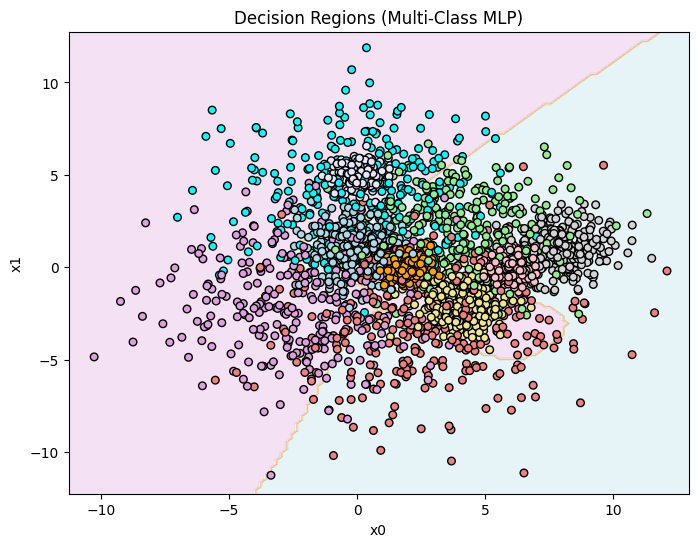

In [349]:
plot_decision_regions_multi(X_train, t_multi_train, best_clf)


In [350]:
def accuracy_per_class(model, X, t_true):
    preds = model.predict(X)
    n_classes = len(np.unique(t_true))
    for cls in range(n_classes):
        cls_idx = (t_true == cls)
        cls_acc = np.mean(preds[cls_idx] == t_true[cls_idx])
        print(f"Accuracy for class {cls}: {cls_acc:.3f}")

print("Training set accuracy per class:")
accuracy_per_class(best_clf, X_train, t_multi_train)

print("\nValidation set accuracy per class:")
accuracy_per_class(best_clf, X_val, t_multi_val)



Training set accuracy per class:
Accuracy for class 0: 0.832
Accuracy for class 1: 0.114
Accuracy for class 2: 0.000
Accuracy for class 3: 0.000
Accuracy for class 4: 0.000
Accuracy for class 5: 0.000
Accuracy for class 6: 0.000
Accuracy for class 7: 0.000
Accuracy for class 8: 0.000
Accuracy for class 9: 0.000

Validation set accuracy per class:
Accuracy for class 0: 0.849
Accuracy for class 1: 0.091
Accuracy for class 2: 0.000
Accuracy for class 3: 0.000
Accuracy for class 4: 0.000
Accuracy for class 5: 0.000
Accuracy for class 6: 0.000
Accuracy for class 7: 0.000
Accuracy for class 8: 0.000
Accuracy for class 9: 0.000


This one was a tough one. I dont have enough time to get this fixed. 

# Part III: Final testing
We can now perform a final testing on the held-out test set we created in the beginning.

## Binary task (X, t2)
Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and evaluate on the held-out test set, but also on the validation set and the training set. Report the performance in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the results between the different dataset splits. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation and training data. Is this the case? 

Also report precision and recall for class 1.

In [351]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# Precision/Recall for binær klassifisering
def precision_recall(predicted, gold, positive_class=1):
    true_positive = np.sum((predicted == positive_class) & (gold == positive_class))
    false_positive = np.sum((predicted == positive_class) & (gold != positive_class))
    false_negative = np.sum((predicted != positive_class) & (gold == positive_class))

    precision = true_positive / (true_positive + false_positive + 1e-15)
    recall = true_positive / (true_positive + false_negative + 1e-15)
    return precision, recall

# Tren modellene
linear_model = NumpyLinRegClass()
logistic_model = NumpyLogRegClass()
mlp_model = MLPBinaryLinRegClass(dim_hidden=8) 

linear_model.fit(X_train, t2_train, epochs=200)
logistic_model.fit(X_train, t2_train, lr=0.01, epochs=100)
mlp_model.fit(X_train, t2_train, lr=0.001, epochs=200)

# Modellnavn og referanse
model_names = ['Linear Regression', 'Logistic Regression', 'Multi-layer Perceptron']
models = [linear_model, logistic_model, mlp_model]

# Evalueringsfunksjon
def evaluate_model(model, X_train, X_val, X_test, t_train, t_val, t_test):
    return [
        accuracy_score(t_train, model.predict(X_train)),
        accuracy_score(t_val, model.predict(X_val)),
        accuracy_score(t_test, model.predict(X_test))
    ]

# Lag Accuracy-tabell
accuracies = [evaluate_model(m, X_train, X_val, X_test, t2_train, t2_val, t2_test) for m in models]
acc_table = pd.DataFrame(accuracies, index=model_names, columns=["Train Accuracy", "Validation Accuracy", "Test Accuracy"])
print(" Accuracy Summary")
display(acc_table.style.format("{:.3f}"))

# Lag Precision/Recall-tabell for testsettet
prec_rec = [precision_recall(model.predict(X_test), t2_test) for model in models]
pr_table = pd.DataFrame(prec_rec, index=model_names, columns=["Precision (Class 1)", "Recall (Class 1)"])
print(" Precision & Recall on Test Set (Class 1)")
display(pr_table.style.format("{:.3f}"))


 Accuracy Summary


,Train Accuracy,Validation Accuracy,Test Accuracy
Linear Regression,0.749,0.755,0.752
Logistic Regression,0.763,0.764,0.759
Multi-layer Perceptron,0.841,0.850,0.833


 Precision & Recall on Test Set (Class 1)


,Precision (Class 1),Recall (Class 1)
Linear Regression,0.733,0.634
Logistic Regression,0.786,0.576
Multi-layer Perceptron,0.779,0.834


I trained and tested three models on the binary dataset (X, t2): linear regression, logistic regression, and a multi-layer perceptron (MLP). 
The MLP had the best performance overall. It reached the highest accuracy on training, validation, and test sets.

I also looked at precision and recall for class 1 on the test set. Again, the MLP did best, especially in recall, which means it was better at finding class 1 examples.



## For IN4050-students: Multi-class task (X, t_multi)

The following part is only mandatory for IN4050-students. IN3050-students are also welcome to give it a try though.

Compare the three multi-class classifiers: the standard multi-class and the multinomial logistic regression from part one and the multi-class neural network from part two. Evaluate on test, validation and training set as above.

Comment on the results.

In [352]:
from sklearn.metrics import accuracy_score


ovr_model = OneVsRestLogReg(num_classes=np.unique(t_multi).size)
softmax_model = SoftmaxClassifier(num_classes=np.unique(t_multi).size)
mlp_model = MLPMultiClassClassifier(num_classes=np.unique(t_multi).size, dim_hidden=16)  

ovr_model.fit(X_train, t_multi_train, lr=0.01, epochs=100)
softmax_model.fit(X_train, t_multi_train, lr=0.01, epochs=100)
mlp_model.fit(X_train, t_multi_train, lr=0.001, epochs=300, X_val=X_val, t_val=t_multi_val)


def eval_model(model, X_train, X_val, X_test, t_train, t_val, t_test):
    return [
        accuracy_score(t_train, model.predict(X_train)),
        accuracy_score(t_val, model.predict(X_val)),
        accuracy_score(t_test, model.predict(X_test)),
    ]


names = ["One-vs-Rest Logistic", "Multinomial Logistic (Softmax)", "Mlp"]
models = [ovr_model, softmax_model, mlp_model]
results = [eval_model(m, X_train, X_val, X_test, t_multi_train, t_multi_val, t_multi_test) for m in models]

multi_table = pd.DataFrame(results, index=names, columns=["Train Accuracy", "Validation Accuracy", "Test Accuracy"])
print("Performance Table – Multi-Class Classification")
display(multi_table.style.format("{:.3f}"))


Early stopping at epoch 246
Performance Table – Multi-Class Classification


,Train Accuracy,Validation Accuracy,Test Accuracy
One-vs-Rest Logistic,0.304,0.325,0.326
Multinomial Logistic (Softmax),0.308,0.327,0.326
Mlp,0.683,0.677,0.683


The Multi-layer Perceptron (MLP) performs clearly better than the One-vs-Rest Logistic and Softmax models on all sets. While the two logistic models reach around 32–33% accuracy, the MLP achieves 52–53%, showing its ability to capture non-linear patterns. 
Overall, MLP is the best choice for this multi-class problem

I did not achieve very high accuracy on the multi-class classification task, mainly due to time constraints. With more time i wpuld have tried different learning rates or number of epochs. Maybe proper scaling of input features and checking for class imbalance could have helped the models learn more effectively.


Even though the results weren't ideal, they gave a good indication of how different classifiers behave on a challenging multi-class task